## 3.1 线性回归

- 线性回归输出是一个连续值， 适用于回归问题
- 分类问题的模型输出离散值， 适用于分类问题
- softmax 回归适用于分类问题

### 3.1.1 线性回归的基本要素

#### 3.1.1.1 模型定义

$\hat y = x_1w_1 + x_2w_2 + b$

#### 3.1.1.2 训练模型

1. 训练数据

$ \hat y^{(i)} = x_1^{(i)}w_1 + x_2^{(i)}w_2 + b$

2. 损失函数

$l(w_1, w_2, b) = \frac{1}{n}\sum_{i=1}^{n}l_i(w_1, w_2, b) = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(x_1^{(i)}w_1 + x_2^{(i)}w_2 + b - y^{(i)})^2$

$ w_1^∗, w_2^∗, b^∗ =  arg min_{w1,w2,b} ℓ(w_1, w_2, b)$

3. 优化函数

#### 3.1.1.3 模型预测

### 3.1.2 线性回归的表示方法

#### 3.1.2.1 神经网络图

![jupyter](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter03/3.1_linreg.svg)

#### 3.1.2.2 矢量计算表达式

### 小结

- 对于线性回归这样一种单层神经网络，它的基本要素包括模型、训练数据、损失函数和优化算法。
- 既可以用神经网络图表示线性回归，又可以用矢量计算表示该模型。
- 应该尽可能采用矢量计算，以提升计算效率。

## 3.2 线性回归的从零开始实现

In [41]:
# 导入常用库
%matplotlib inline
import torch
import torch.nn as nn
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [191]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)
        
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data
        
def load_data_fashion_mnist(batch_size):
    mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True,  download=True, transform=transforms.ToTensor())
    mnist_test  = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
    num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

### 3.2.1 生成数据集

随机生成数据集

In [15]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

labels.shape

torch.Size([1000])

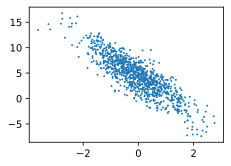

In [16]:
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

### 3.2.2 读取数据

In [32]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.1045,  0.1717],
        [ 0.1144, -0.9354],
        [ 0.8209, -0.4059],
        [-0.4332, -0.4034],
        [-0.1131,  0.7009],
        [ 1.2962, -1.5992],
        [ 1.9067, -1.4180],
        [ 0.9951,  0.0508],
        [-1.9479,  0.2825],
        [ 0.3893,  0.2377]]) tensor([ 3.4197,  7.5935,  7.2279,  4.7055,  1.5884, 12.2353, 12.8378,  6.0097,
        -0.6601,  4.1798])


### 3.2.3 初始化模型参数

In [18]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

### 3.2.4 定义模型

In [20]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

### 3.2.5 定义损失函数

In [22]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 3.2.6 定义优化算法

In [23]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

### 3.2.7 训练模型

In [26]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X 和 y 分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零b
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))
    
print(true_w, '\n', w)
print(true_b, '\n', b)

epoch 1, loss 0.000047
epoch 2, loss 0.000048
epoch 3, loss 0.000047
[2, -3.4] 
 tensor([[ 2.0000],
        [-3.3998]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)


## 3.3 线性回归的简洁实现

### 3.3.1 生成数据集

In [35]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

### 3.3.2 读取数据

In [38]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

for X, y in data_iter:
    print(X, y)
    break

tensor([[ 0.9884, -0.5826],
        [-1.0990,  0.6400],
        [-1.2309,  0.4310],
        [-0.9645,  0.9705],
        [ 0.0261, -1.0323],
        [ 0.7432, -0.1931],
        [ 0.8969,  0.2839],
        [-1.1163, -1.0058],
        [-0.1179, -1.1987],
        [ 0.6080,  0.4295]]) tensor([ 8.1477, -0.1707,  0.2716, -1.0246,  7.7633,  6.3357,  5.0232,  5.3870,
         8.0339,  3.9399])


### 3.3.3 定义模型

In [43]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

for param in net.parameters():
    print(param)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Parameter containing:
tensor([[ 0.4602, -0.1744]], requires_grad=True)
Parameter containing:
tensor([0.2360], requires_grad=True)


### 3.3.4 初始化模型参数

In [45]:
from torch.nn import init

init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

### 3.3.5 定义损失函数

In [46]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法

In [47]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 3.3.7 训练模型

In [48]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000248
epoch 2, loss: 0.000081
epoch 3, loss: 0.000125


In [50]:
dense = net.linear
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9990, -3.3996]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1993], requires_grad=True)


### 小结

- 使用PyTorch可以更简洁地实现模型。
- torch.utils.data模块提供了有关数据处理的工具
- torch.nn模块定义了大量神经网络的层
- torch.nn.init模块定义了各种初始化方法
- torch.optim模块提供了很多常用的优化算法。

## 3.4 softmax回归

和线性回归不同，softmax回归的输出单元从一个变成了多个，且引入了 softmax 运算使输出更适合离散值的预测和训练

### 3.4.1 分类问题

### 3.4.2 softmax回归模型

- softmax 回归将输入特征与权重做线性叠加。
- softmax 回归的输出值个数等于标签里的类别数

$ o_1 =	x_1w_{11} + x_2w_{21} + x_3w_{31} + x_4w_{41} + b_1 $
 
$ o_2 = x_1w_{12} + x_2w_{22} + x_3w_{32} + x_4w_{42} + b_2 $

$ o_3 = x_1w_{13} + x_2w_{23} + x_3w_{33} + x_4w_{43} + b_3 $

![jupyter](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter03/3.4_softmaxreg.svg)

使用线性回归输出层的输出做分类有两个问题

- 由于输出层的输出值的范围不确定，很难直观上判断这些值的意义
- 由于真实标签是离散值，这些离散值与不确定范围的输出值之间的误差难以衡量

softmax 运算符解决了以上两个问题。它将输出值变换成**值为正且和为1** 的概率分布：

$$ \hat y_1, \hat y_2, \hat y_ 3 = softmax(o1,o2,o3) $$ 

其中

$$ \hat y_1 = \frac{exp(o_1)}{\sum_{i=1}^{3}exp(o_i)}, \hat y_2 = \frac{exp(o_2)}{\sum_{i=1}^{3}exp(o_i)}, \hat y_3 = \frac{exp(o_3)}{\sum_{i=1}^{3}exp(o_i)} $$ 

### 3.4.3 单样本分类的矢量计算表达式

$ o^{(i)} =x^{(i)}W + b $
 
$ y^{(i)} = softmax(o^{(i)}) $

### 3.4.4 小批量样本分类的矢量计算表达式

$ O = XW + b $

$ \hat Y = softmax(O) $

### 3.4.5 交叉熵损失函数

衡量两个概率分布差异的测量函数

交叉熵函数:

$$ H(y_{(i)}, \hat y_{(i)})=−\sum_{j=1}^{q}y_j^{(i)}log\hat y_j^{(i)} $$

交叉熵只关心对正确类别的预测概率，因为只要其值足够大，就可以确保分类结果正确


交叉熵损失函数:

$$ ℓ(Θ)= \frac{1}{n}\sum_{i=1}^{n}H(y_{(i)}, \hat y_{(i)}) $$

最小化交叉熵损失函数等价于最大化训练数据集所有标签类别的联合预测概率

### 3.4.6 模型预测及评价

使用准确率（accuracy）来评价模型的表现。准确率等于正确预测数量与总预测数量之比

### 小结

- softmax回归适用于分类问题。它使用softmax运算输出类别的概率分布。
- softmax回归是一个单层神经网络，输出个数等于分类问题中的类别个数。
- 交叉熵适合衡量两个概率分布的差异。

## 3.5 图像分类数据集（Fashion-MNIST）

torchvision主要由以下几部分构成：

- torchvision.datasets: 一些加载数据的函数及常用的数据集接口；
- torchvision.models: 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等；
- torchvision.transforms: 常用的图片变换，例如裁剪、旋转等；
- torchvision.utils: 其他的一些有用的方法。

### 3.5.1 获取数据集

In [60]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

In [67]:
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True,  download=True, transform=transforms.ToTensor())
mnist_test  = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [68]:
feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height x Width

torch.Size([1, 28, 28]) 9


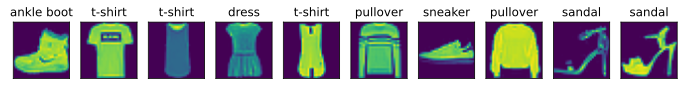

In [75]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

### 3.5.2 读取小批量

In [76]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [77]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

1.21 sec


## 3.6 softmax回归的从零开始实现

### 3.6.1 获取和读取数据

In [78]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 3.6.2 初始化模型参数

In [79]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [80]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 3.6.3 实现softmax运算

In [82]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [83]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1653, 0.1791, 0.2303, 0.2753, 0.1500],
        [0.1927, 0.1779, 0.1723, 0.2161, 0.2410]]) tensor([1.0000, 1.0000])


### 3.6.4 定义模型

In [84]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

### 3.6.5 定义损失函数

In [85]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

### 3.6.6 计算分类准确率

In [90]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [88]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [89]:
print(evaluate_accuracy(test_iter, net))

0.0906


### 3.6.7 训练模型

In [94]:
num_epochs, lr = 10, 0.1

# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.4747, train acc 0.839, test acc 0.826
epoch 2, loss 0.4646, train acc 0.843, test acc 0.831
epoch 3, loss 0.4584, train acc 0.845, test acc 0.833
epoch 4, loss 0.4526, train acc 0.847, test acc 0.834
epoch 5, loss 0.4476, train acc 0.848, test acc 0.833
epoch 6, loss 0.4435, train acc 0.849, test acc 0.829
epoch 7, loss 0.4391, train acc 0.851, test acc 0.834
epoch 8, loss 0.4360, train acc 0.851, test acc 0.835
epoch 9, loss 0.4327, train acc 0.852, test acc 0.837
epoch 10, loss 0.4311, train acc 0.853, test acc 0.832


### 3.6.8 预测

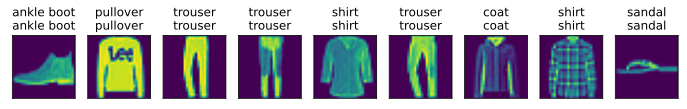

In [96]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])

## 3.7 softmax回归的简洁实现

### 3.7.1 获取和读取数据

In [98]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 3.7.2 定义和初始化模型

In [99]:
num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x shape: (batch, 1, 28, 28)
        y = self.linear(x.view(x.shape[0], -1))
        return y

net = LinearNet(num_inputs, num_outputs)

In [100]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

In [101]:
from collections import OrderedDict

net = nn.Sequential(
    # FlattenLayer(),
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        ('flatten', FlattenLayer()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)

In [102]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 3.7.3 softmax和交叉熵损失函数

In [103]:
loss = nn.CrossEntropyLoss()

### 3.7.4 定义优化算法

In [104]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

### 3.7.5 训练模型

In [105]:
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.749, test acc 0.788
epoch 2, loss 0.0022, train acc 0.814, test acc 0.772
epoch 3, loss 0.0021, train acc 0.824, test acc 0.817
epoch 4, loss 0.0020, train acc 0.833, test acc 0.811
epoch 5, loss 0.0019, train acc 0.837, test acc 0.825


### 小结

- PyTorch提供的函数往往具有更好的数值稳定性。
- 可以使用PyTorch更简洁地实现softmax回归。

## 3.8 多层感知机

### 3.8.1 隐藏层

多层感知机在单层神经网络的基础上引入了一到多个隐藏层（hidden layer）。隐藏层位于输入层和输出层之间

![jupyter](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter03/3.8_mlp.svg)

先来看一种含单隐藏层的多层感知机的设计

$ H = XW_h + b_h $

$ O = HW_o +b_o $

将以上两个式子联立起来

$ O=( XW_h + b_h )W_o + b_o =XW_hW_o + b_hW_o + b_o $

从联立后的式子可以看出，虽然神经网络引入了隐藏层，却依然等价于一个单层神经网络

### 3.8.2 激活函数

上述问题的根源在于全连接层只是对数据做仿射变换（affine transformation），而多个仿射变换的叠加仍然是一个仿射变换。解决问题的一个方法是引入非线性变换，例如对隐藏变量使用按元素运算的非线性函数进行变换，然后再作为下一个全连接层的输入。这个非线性函数被称为激活函数（activation function）。

#### 3.8.2.1 ReLU函数

$$ ReLU(x)=max(x,0) $$

In [112]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

ReLU 函数

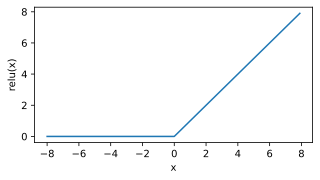

In [113]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

ReLU 函数导数

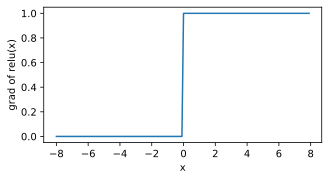

In [114]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

#### 3.8.2.2 sigmoid函数

sigmoid函数可以将元素的值变换到0和1之间

$$ sigmoid(x)= \frac{1}{1+exp(−x)} $$

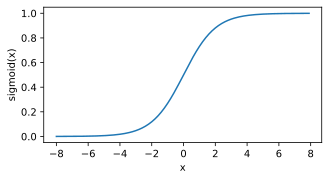

In [116]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

sigmoid函数的导数。当输入为0时，sigmoid函数的导数达到最大值0.25；当输入越偏离0时，sigmoid函数的导数越接近0

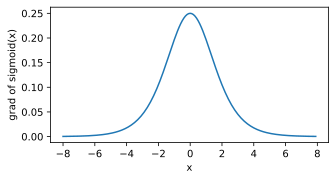

In [117]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

#### 3.8.2.3 tanh函数

tanh（双曲正切）函数可以将元素的值变换到-1和1之间

$$ tanh(x)= \frac{1-exp(−2x)}{1+exp(−2x)} $$

tanh函数。当输入接近0时，tanh函数接近线性变换

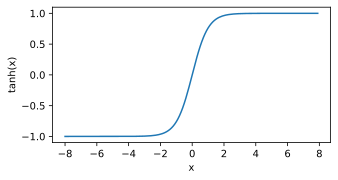

In [120]:
y = x.tanh()
xyplot(x, y, 'tanh')

tanh函数的导数。当输入为0时，tanh函数的导数达到最大值1；当输入越偏离0时，tanh函数的导数越接近0

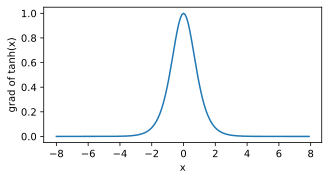

In [121]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

### 3.8.3 多层感知机

多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换

$$ H = ϕ(XW_h + b_h) $$
$$ O = HW_o + b_o $$

其中 ϕ 表示激活函数。
- 在分类问题中，可以对输出 O 做softmax运算，并使用 softmax 回归中的**交叉熵损失函数**。 
- 在回归问题中，将输出层的输出个数设为1，并将输出 O 直接提供给线性回归中使用的**平方损失函数**。

### 小结

- 多层感知机在输出层与输入层之间加入了一个或多个全连接隐藏层，并通过激活函数对隐藏层输出进行变换。
- 常用的激活函数包括 ReLU 函数、sigmoid 函数和 tanh 函数。

## 3.9 多层感知机的从零开始实现

### 3.9.1 获取和读取数据

In [126]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 3.9.2 定义模型参数

In [127]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

### 3.9.3 定义激活函数

In [128]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

### 3.9.4 定义模型

In [129]:
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

### 3.9.5 定义损失函数

In [130]:
loss = torch.nn.CrossEntropyLoss()

### 3.9.6 训练模型

In [131]:
num_epochs, lr = 5, 100.0
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0031, train acc 0.713, test acc 0.763
epoch 2, loss 0.0019, train acc 0.822, test acc 0.795
epoch 3, loss 0.0017, train acc 0.844, test acc 0.801
epoch 4, loss 0.0016, train acc 0.854, test acc 0.845
epoch 5, loss 0.0014, train acc 0.863, test acc 0.863


## 3.10 多层感知机的简洁实现

### 3.10.1 定义模型

In [133]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs), 
        )

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

### 3.10.2 读取数据并训练模型

In [135]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.709, test acc 0.759
epoch 2, loss 0.0019, train acc 0.822, test acc 0.800
epoch 3, loss 0.0016, train acc 0.846, test acc 0.822
epoch 4, loss 0.0015, train acc 0.856, test acc 0.834
epoch 5, loss 0.0014, train acc 0.866, test acc 0.837


## 3.11 模型选择、欠拟合和过拟合

当模型在训练数据集上更准确时，它在测试数据集上却不一定更准确。这是为什么呢？

### 3.11.1 训练误差和泛化误差

- 训练误差指模型在训练数据集上表现出的误差
- 泛化误差指模型在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似

由于无法从训练误差估计泛化误差，一味地降低训练误差并不意味着泛化误差一定会降低。
机器学习模型应关注降低泛化误差。

### 3.11.2 模型选择

在机器学习中，通常需要评估若干候选模型的表现并从中选择模型。这一过程称为模型选择（model selection）

#### 3.11.2.1 验证数据集

从严格意义上讲，测试集只能在所有超参数和模型参数选定后使用一次。不可以使用测试数据选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。鉴于此，我们可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。

#### 3.11.2.2 K折交叉验证

### 3.11.3 欠拟合和过拟合

- 模型无法得到较低的训练误差，我们将这一现象称作欠拟合
- 模型的训练误差远小于它在测试数据集上的误差，我们称该现象为过拟合（overfitting）

#### 3.11.3.1 模型复杂度

![jupyter](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter03/3.11_capacity_vs_error.svg)

给定训练数据集，如果模型的复杂度过低，很容易出现欠拟合；如果模型复杂度过高，很容易出现过拟合。应对欠拟合和过拟合的一个办法是针对数据集选择合适复杂度的模型

#### 3.11.3.2 训练数据集大小

- 影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。
- 一般来说，如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生
- 在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，例如层数较多的深度学习模型。

### 3.11.4 多项式函数拟合实验

#### 3.11.4.1 生成数据集

In [141]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

#### 3.11.4.2 定义、训练和测试模型

In [143]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [144]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

#### 3.11.4.3 三阶多项式函数拟合（正常）

final epoch: train loss 0.0009130393736995757 test loss 0.0009331192704848945
weight: tensor([[ 1.2044, -3.4037,  5.5954]]) 
bias: tensor([4.9992])


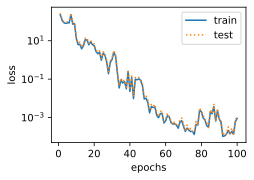

In [145]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

#### 3.11.4.4 线性函数拟合（欠拟合）

final epoch: train loss 336.0308532714844 test loss 385.6973876953125
weight: tensor([[21.2830]]) 
bias: tensor([5.0995])


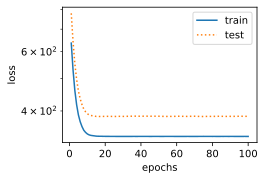

In [146]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

#### 3.11.4.5 训练样本不足（过拟合）

final epoch: train loss 1.0485107898712158 test loss 203.50619506835938
weight: tensor([[0.9143, 1.5650, 2.8903]]) 
bias: tensor([3.2076])


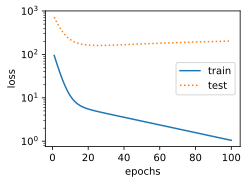

In [147]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

### 小结

- 由于无法从训练误差估计泛化误差，一味地降低训练误差并不意味着泛化误差一定会降低。机器学习模型应关注降低泛化误差。
- 可以使用验证数据集来进行模型选择。
- 欠拟合指模型无法得到较低的训练误差，过拟合指模型的训练误差远小于它在测试数据集上的误差。
- 应选择复杂度合适的模型并避免使用过少的训练样本。

## 3.12 权重衰减

应对过拟合问题的常用方法：权重衰减（weight decay）

### 3.12.1 方法

权重衰减等价于 $L_2$ 范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段

$L_2$ 范数正则化在模型原损失函数基础上添加 $L_2$ 范数惩罚项，从而得到训练所需要最小化的函数。$L_2$ 范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积

带有 $L_2$ 范数惩罚项的新损失函数为


$$ ℓ(w_1, w_2, b )+ \frac{λ}{2n}∥w∥^2 $$

其中超参数λ>0λ>0。当权重参数均为0时，惩罚项最小。当λλ较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近0

权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效

### 3.12.2 高维线性回归实验

In [152]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

### 3.12.3 从零开始实现

#### 3.12.3.1 初始化模型参数

In [153]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### 3.12.3.2 定义L2 范数惩罚项

In [154]:
def l2_penalty(w):
    return (w**2).sum() / 2

#### 3.12.3.3 定义训练和测试

In [158]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = linreg, squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

#### 3.12.3.4 观察过拟合

L2 norm of w: 12.278502464294434


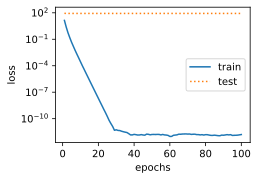

In [159]:
fit_and_plot(lambd=0)

#### 3.12.3.5 使用权重衰减

L2 norm of w: 0.03515380248427391


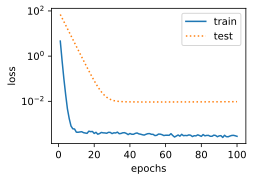

In [160]:
fit_and_plot(lambd=3)

### 3.12.4 简洁实现

直接在构造优化器实例时通过weight_decay参数来指定权重衰减超参数

In [166]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, b=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减

    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 12.60577392578125


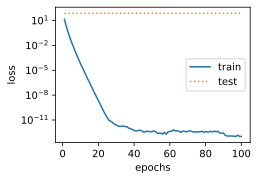

In [168]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.04559963569045067


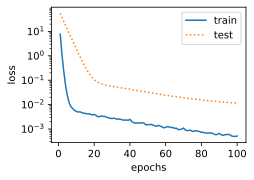

In [169]:
fit_and_plot_pytorch(3)

### 小结

- 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
- 权重衰减等价于 $L_2$ 范数正则化，通常会使学到的权重参数的元素较接近0。
- 权重衰减可以通过优化器中的weight_decay超参数来指定。
- 可以定义多个优化器实例对不同的模型参数使用不同的迭代方法。

## 3.13 丢弃法

除了前一节介绍的权重衰减以外，深度学习模型常常使用丢弃法（dropout） 来应对过拟合问题

### 3.13.1 方法

对该隐藏层使用丢弃法，该层的隐藏单元将有一定概率被丢弃, 但丢弃法不改变其输入的期望值

如下图所示，其中 $h_2$ 和 $h_5$ 被清零。这时输出值的计算不再依赖 $h_2$ 和 $h_5$ ，在反向传播时，与这两个隐藏单元相关的权重的梯度均为0。由于在训练中隐藏层神经元的丢弃是随机的，即 $h_1$,…,$h_5$ 都有可能被清零，输出层的计算无法过度依赖 $h_1$,…,$h_5$ 中的任一个，从而在训练模型时起到正则化的作用，并可以用来应对过拟合。

 ![jupyter](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter03/3.13_dropout.svg)
 
 在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法。

### 3.13.2 从零开始实现

In [173]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np

def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()

    return mask * X / keep_prob

In [174]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

#### 3.13.2.1 定义模型参数

In [175]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

#### 3.13.2.2 定义模型

In [176]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3

In [177]:
# 本函数已保存在d2lzh_pytorch
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() # 改回训练模式
        else: # 自定义的模型
            if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置成False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n

#### 3.13.2.3 训练和测试模型

In [179]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()

if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0045, train acc 0.559, test acc 0.742
epoch 2, loss 0.0023, train acc 0.785, test acc 0.803
epoch 3, loss 0.0019, train acc 0.819, test acc 0.816
epoch 4, loss 0.0017, train acc 0.837, test acc 0.837
epoch 5, loss 0.0016, train acc 0.849, test acc 0.837


### 3.13.3 简洁实现

在PyTorch中，我们只需要在全连接层后添加Dropout层并指定丢弃概率。在训练模型时，Dropout层将以指定的丢弃概率随机丢弃上一层的输出元素；在测试模型时（即model.eval()后），Dropout层并不发挥作用。

In [181]:
net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [182]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0048, train acc 0.531, test acc 0.673
epoch 2, loss 0.0023, train acc 0.783, test acc 0.809
epoch 3, loss 0.0020, train acc 0.818, test acc 0.808
epoch 4, loss 0.0018, train acc 0.835, test acc 0.823
epoch 5, loss 0.0017, train acc 0.844, test acc 0.826


### 小结

- 我们可以通过使用丢弃法应对过拟合。
- 丢弃法只在训练模型时使用。

## 3.14 正向传播、反向传播和计算图

- 正向传播（forward propagation）的计算，即对输入计算模型输出，
- 通过autograd模块来调用系统自动生成的backward函数计算梯度。
- 基于反向传播（back-propagation）算法的自动求梯度极大简化了深度学习模型训练算法的实现

### 3.14.1 正向传播

正向传播是指对神经网络沿着从输入层到输出层的顺序，依次计算并存储模型的中间变量（包括输出）

### 3.14.2 正向传播的计算图

 ![jupyter](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter03/3.14_forward.svg)

### 3.14.3 反向传播

反向传播指的是计算神经网络参数梯度的方法。总的来说，反向传播依据微积分中的链式法则，沿着从输出层到输入层的顺序，依次计算并存储目标函数有关神经网络各层的中间变量以及参数的梯度

### 3.14.4 训练深度学习模型

在模型参数初始化完成后，我们交替地进行正向传播和反向传播，并根据反向传播计算的梯度迭代模型参数。

### 小结

- 正向传播沿着从输入层到输出层的顺序，依次计算并存储神经网络的中间变量。
- 反向传播沿着从输出层到输入层的顺序，依次计算并存储神经网络中间变量和参数的梯度。
- 在训练深度学习模型时，正向传播和反向传播相互依赖。

## 3.15 数值稳定性和模型初始化

深度模型有关数值稳定性的典型问题是衰减（vanishing）和爆炸（explosion）

### 3.15.1 衰减和爆炸

假设输入和所有层的权重参数都是标量，如权重参数为0.2和5，多层感知机的第30层输出为输入X 分别与$0.2^{30}≈1×10^{−21}$ （衰减）和 $5^{30}≈9×10^{20}$ （爆炸）的乘积。类似地，当层数较多时，梯度的计算也更容易出现衰减或爆炸。

### 3.15.2 随机初始化模型参数

通常将神经网络的模型参数，特别是权重参数，进行随机初始化。

#### 3.15.2.1 PyTorch的默认随机初始化

#### 3.15.2.2 Xavier随机初始化

### 小结

- 深度模型有关数值稳定性的典型问题是衰减和爆炸。当神经网络的层数较多时，模型的数值稳定性容易变差。
- 我们通常需要随机初始化神经网络的模型参数，如权重参数。